In [2]:
import sgp4
from sgp4.api import Satrec, jday
import numpy as np
import datetime as dt
import time
import pyproj
import dask
from dask import bag as db
from dask.distributed import Client,LocalCluster

In [ ]:
!pip install sgp4 --quiet
!pip install pyproj --quiet

1. Text file has Tle lines we have to obtain the co-ordinates for one day with time frame of one minute.(get_satellite_positions)
2. Convert the co-ordinates to longitude, latitude and laltitude.(ecef2lla,convert_to_lla_single)
3. Compare within a given range of latitude and longitude.(filter_positions)
4. Code Optimization with Distributed Computing.(Using Dask Library)


In [3]:
%%time

def create_satellite_objects(tle_lines):
    #sgp4 Library - Data Source Library.
    satellites = []
    for line in tle_lines:
        satellite = Satrec.twoline2rv(line[1], line[2])
        satellites.append([satellite,line[0]])
    return satellites

def get_satellite_positions(satellites, start_time, end_time, interval):
    sat_positions = []
    error_satpositions = []
    delta = dt.timedelta(minutes=interval)
    current_time = start_time

    while current_time <= end_time:
        jd, fr = jday(current_time.year, current_time.month, current_time.day,
                      current_time.hour, current_time.minute, current_time.second)
        for satellite in satellites:
            e, r, v = satellite[0].sgp4(jd, fr)
            if e == 0:
                sat_positions.append([satellite[1],current_time, r, v])
            elif not e==0 :
                error_satpositions.append([satellite[1],current_time, r, v])
                
        current_time += delta
    return sat_positions,error_satpositions

# Load TLEs
with open(r"C:\Users\yaswa\Downloads\Assignment_Code Optimization\Assignment_Code Optimization\Assignment_Code Optimization\30sats.txt", 'r') as file:
    lines = file.readlines()
tle_lines = [(lines[i], lines[i + 1],lines[i+2]) for i in range(0, len(lines), 3)]

# Create satellite objects
satellites = create_satellite_objects(tle_lines)

# Get positions for one day
start_time = dt.datetime(2024, 1, 1, 0, 0, 0)
end_time = dt.datetime(2024, 1, 1, 23, 59, 59)
positions = get_satellite_positions(satellites, start_time, end_time, 1)[0]


CPU times: total: 156 ms
Wall time: 297 ms


In [ ]:
#get_satellite_positions(satellites, start_time, end_time, 1)[1]

In [5]:
transformer = pyproj.Transformer.from_proj(
    pyproj.Proj(proj="geocent", ellps="WGS84", datum="WGS84"),
    pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84"),
    always_xy=True
) #Intializing Transformer Object.

In [10]:
lat_min, lat_max = -67,56
lon_min, lon_max = -54,65

In [11]:
%time

def ecef2lla(pos_x, pos_y, pos_z):
    ecef = pyproj.Proj(proj="geocent", ellps="WGS84", datum="WGS84")
    lla = pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84")
    lon, lat, alt = pyproj.transform(ecef, lla, pos_x, pos_y, pos_z, radians=False)
    return lon, lat, alt

def convert_to_lla_single(position):

    name, timestamp, r, v = position
    lon, lat, alt = ecef2lla(r[0], r[1], r[2])

    return name, timestamp, lon, lat, alt

def filter_positions(lla_positions, lat_min, lat_max, lon_min, lon_max):
    filtered_positions = []
    for time, lon, lat, alt in lla_positions:
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            filtered_positions.append((time, lon, lat, alt))
    return filtered_positions



CPU times: total: 0 ns
Wall time: 0 ns


# Distributed Computing


1. We can Replace Local Cluster with available Cloud Cluster and the code is production ready.
2. Cluster has n_workers argument but no need to pass as Dask can automatically assign workers based on Computation resources.
3. We can use Adaptive Scaling for setting max and min workers.(Cloud Clusters)

In [35]:
!pip install dask-labextension==6.2.0 --quiet #For Good Dashboards using Jupyter Lab

ERROR: Invalid requirement: '#For'


In [36]:
cluster = LocalCluster()
cluster

In [18]:
client = Client(cluster)

In [17]:
%%time

def ecef2lla(pos_x, pos_y, pos_z):
    ecef = pyproj.Proj(proj="geocent", ellps="WGS84", datum="WGS84")
    lla = pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84")
    lon, lat, alt = pyproj.transform(ecef, lla, pos_x, pos_y, pos_z, radians=False)
    return lon, lat, alt

def convert_to_lla_single(position):

    name, timestamp, r, v = position
    lon, lat, alt = ecef2lla(r[0], r[1], r[2])

    return name, timestamp, lon, lat, alt
def convert_and_filter(positions, lat_min, lat_max, lon_min, lon_max, use_multithreading=True, n_workers=8):
   
    # Create a Dask bag from the positions
    tasks = db.from_sequence(positions)

    # Map the conversion function to each position
    lla_positions = tasks.map(lambda pos: convert_to_lla_single(pos))

    # Filter the results
    filtered_positions = lla_positions.filter(lambda pos: lat_min <= pos[3] <= lat_max and lon_min <= pos[2] <= lon_max)

    # Compute the filtered positions
    results = filtered_positions.compute()

    return results

  
lla_positions_filtered_mt = convert_and_filter(positions, lat_min, lat_max, lon_min, lon_max)
end = time.time()
print(end-start)

30.172024488449097


In [50]:
client.close()
cluster.close()

### Computation Time



1. Sequential Approach Takes 55 sec and where as Dask Approach takes 30 secs.(For 41 Satellites). We can Scale to Cloud Cluster for 30000 satellites
2. Most of the time is wasted at function ecef2lla

# Alternative Approach 


1. As ecef2lla function taking time I have Updated the function and Intialized a Transformer Object Before hand.
2. This step reduces the Computation time by a Margin.

In [18]:
# Sequential Approach 
%%time
from pyproj import Transformer

import time
start = time.time()
def ecef2lla_updated(pos_x, pos_y, pos_z,transformer):
    #start = time.time()
    
    lon, lat, alt = transformer.transform(pos_x, pos_y, pos_z, radians=False)
    #end = time.time()
    #print(end -start)
    return lon, lat, alt
def ecef2lla(pos_x, pos_y, pos_z):
    ecef = pyproj.Proj(proj="geocent", ellps="WGS84", datum="WGS84")
    lla = pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84")
    lon, lat, alt = pyproj.transform(ecef, lla, pos_x, pos_y, pos_z, radians=False)
    return lon, lat, alt


def convert_to_lla(positions):
    lla_positions = []
    for name,time, r, v in positions:
        lon, lat, alt = ecef2lla(r[0], r[1], r[2])
        lla_positions.append((time, lon, lat, alt))
    return lla_positions



def convert_to_lla_updated(positions,transformer):
    
    lla_positions = []
    for name,time, r, v in positions:
        lon, lat, alt = ecef2lla_updated(r[0], r[1], r[2],transformer)
        lla_positions.append([name,time, lon, lat, alt])

    return lla_positions

lla_positions = convert_to_lla_updated(positions,transformer)
def filter_positions(lla_positions, lat_min, lat_max, lon_min, lon_max):
    filtered_positions = []
    for name,time, lon, lat, alt in lla_positions:
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            filtered_positions.append((time, lon, lat, alt))
    return filtered_positions

lat_min, lat_max = -45.09096, 65.74973
lon_min, lon_max = -14.79778, 10.58196
filtered_positions = filter_positions(lla_positions, lat_min, lat_max, lon_min, lon_max)


0.11927366256713867


In [19]:
cluster = LocalCluster()
cluster

In [20]:
client = Client(cluster)

In [21]:
%%time
#Distributed Computing.
import dask.bag as db
import pyproj


# Define the convert_to_lla_single function
def convert_to_lla_single(position, transformer):
    name, timestamp, r, v = position
    lon, lat, alt = ecef2lla_updated(r[0], r[1], r[2], transformer)
    return name, timestamp, lon, lat, alt

# Define the filter_positions function
def filter_positions(lla_positions, lat_min, lat_max, lon_min, lon_max):
    filtered_positions = []
    for time, lon, lat, alt in lla_positions:
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            filtered_positions.append((time, lon, lat, alt))
    return filtered_positions


# Define your transformer object
transformer = pyproj.Transformer.from_proj(
    pyproj.Proj(proj="geocent", ellps="WGS84", datum="WGS84"),
    pyproj.Proj(proj="latlong", ellps="WGS84", datum="WGS84"),
    always_xy=True
)

# Create a Dask bag from the list of positions
positions_bag = db.from_sequence(positions)

# Convert positions to LLA coordinates
lla_positions_bag = positions_bag.map(lambda pos: convert_to_lla_single(pos, transformer))

# Filter LLA positions
filtered_positions_bag = lla_positions_bag.filter(lambda pos: lat_min <= pos[3] <= lat_max and lon_min <= pos[2] <= lon_max)

# Compute the result
filtered_positions_result = filtered_positions_bag.compute()


CPU times: total: 641 ms
Wall time: 3.5 s


In [ ]:
client.close()
cluster.close()

# Results

1. Sequential Approach is Better than Dask Approach.
2. Dask seems to be infeffective to handle Pre determined Objects 
3. By below Task stream image, there's lot of waiting time.

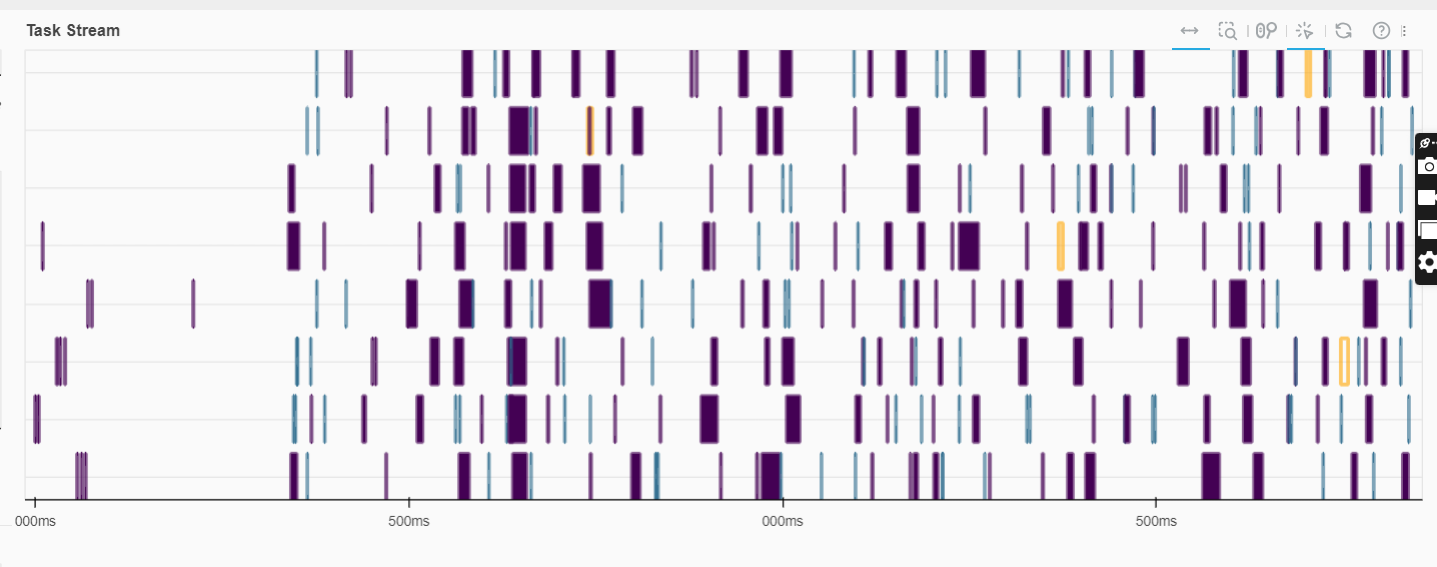